File 'uk_health_expenditure_gdp_wbgapi.csv' already exists. Using existing file.
--- Main Dataset Head ---
   Unnamed: 0 iso2c         country  year  NY.GDP.PCAP.CD  SP.DYN.IMRT.IN
0           1    GB  United Kingdom  1960     1380.306241            22.9
1           2    GB  United Kingdom  1961     1452.544709            22.5
2           3    GB  United Kingdom  1962     1513.651449            22.0
3           4    GB  United Kingdom  1963     1592.614477            21.4
4           5    GB  United Kingdom  1964     1729.399978            20.8

--- UK Main Data (GDP, IMR) for 1960-2015 ---
   year  GDP_per_capita   IMR
0  1960     1380.306241  22.9
1  1961     1452.544709  22.5
2  1962     1513.651449  22.0
3  1963     1592.614477  21.4
4  1964     1729.399978  20.8

--- ML Analysis 1: GDP vs IMR (1960-2015) ---

Linear Regression (1960-2015):
  MSE: 12.00469569965613
  R2: 0.7457425325271538

Polynomial Regression (Degree 2, 1960-2015):
  MSE: 3.4288435137023563
  R2: 0.9273776620443

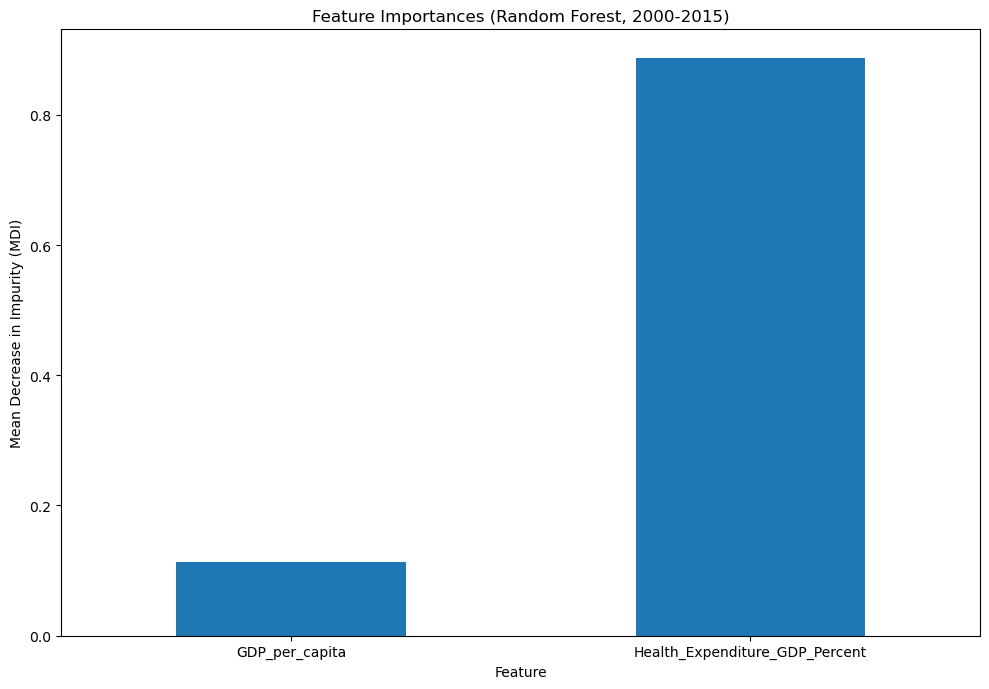

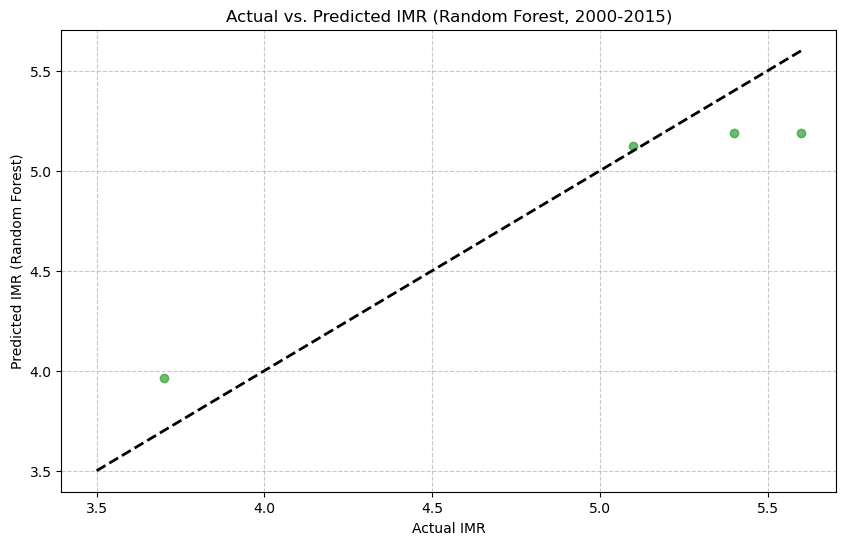

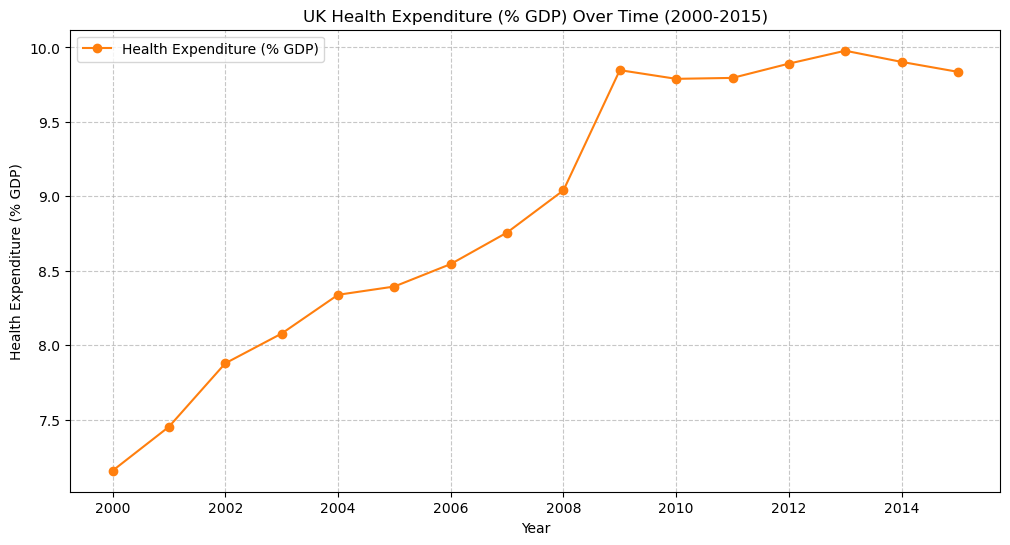


--- Generating Additional Plots (1960-2015 data) ---


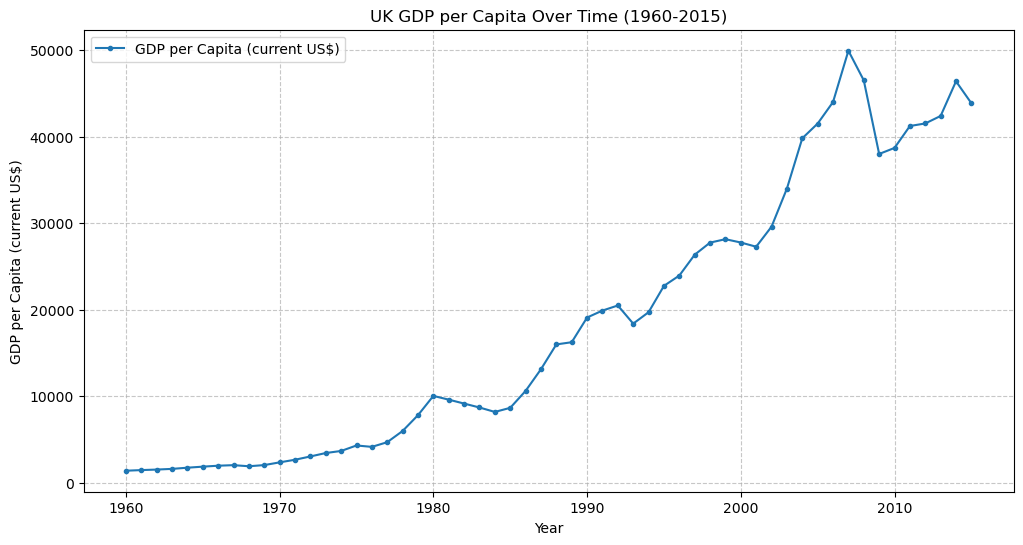

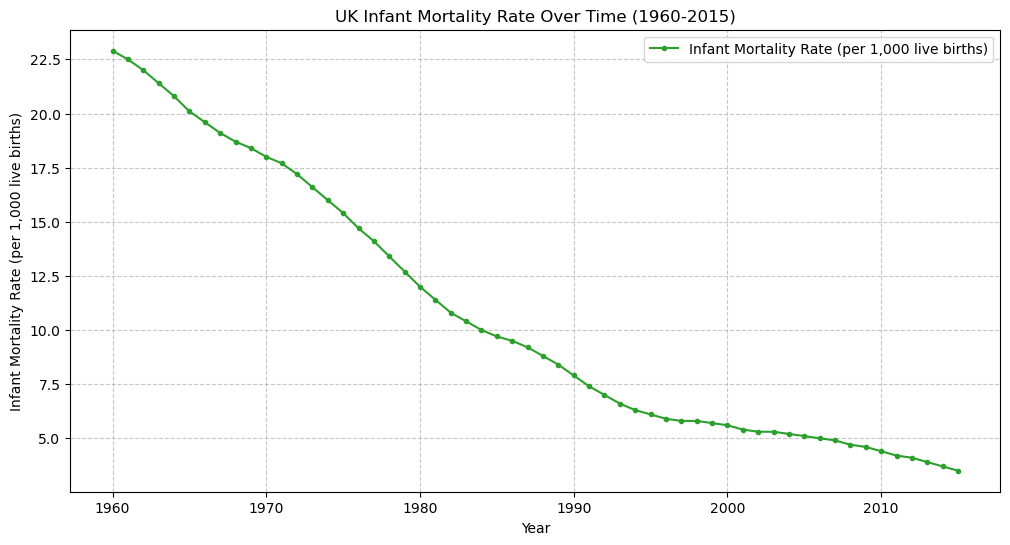

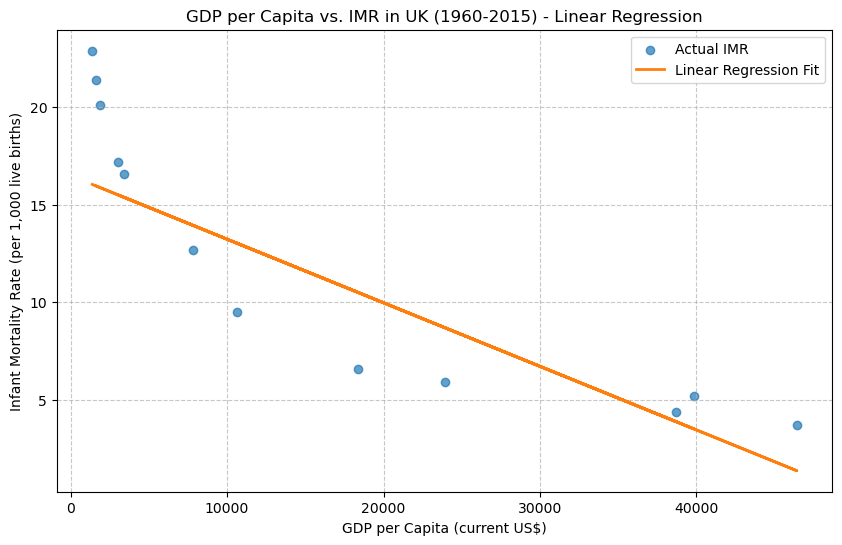

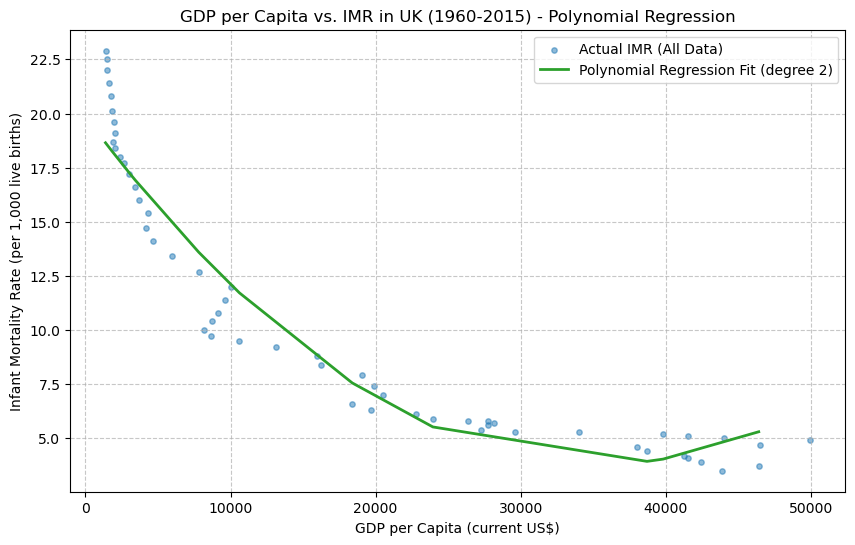

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wbgapi as wb # Added wbgapi import


# --- Define constants for WDI data download ---
# Health expenditure data will be saved in the same directory as the script
HEALTH_EXPENDITURE_FILE_NAME = "uk_health_expenditure_gdp_wbgapi.csv"
COUNTRY_CODE_WDI = "GBR" # UK's ISO 3166 alpha-3 code
INDICATOR_CODE_WDI = "SH.XPD.CHEX.GD.ZS" # Health expenditure, current (% of GDP)
YEAR_RANGE_WDI = range(2000, 2016) # Years 2000 to 2015 inclusive

# --- Function to download health expenditure data using wbgapi ---
def download_health_expenditure_data_wdi():
    if os.path.exists(HEALTH_EXPENDITURE_FILE_NAME):
        print(f"File '{HEALTH_EXPENDITURE_FILE_NAME}' already exists. Using existing file.")
        return

    print(f"File '{HEALTH_EXPENDITURE_FILE_NAME}' not found. Downloading data from World Bank...")
    try:
        df = wb.data.DataFrame(INDICATOR_CODE_WDI, COUNTRY_CODE_WDI, time=YEAR_RANGE_WDI)
        df = df.reset_index()
        df_long = df.melt(id_vars='economy', var_name='Year', value_name='Health_Expenditure_GDP_Percent')
        df_long['Year'] = df_long['Year'].str.replace('YR', '').astype(int)
        df_final = df_long[['Year', 'Health_Expenditure_GDP_Percent']]
        df_final.to_csv(HEALTH_EXPENDITURE_FILE_NAME, index=False)
        print(f"Data successfully downloaded and saved to '{HEALTH_EXPENDITURE_FILE_NAME}'.")
    except Exception as e:
        print(f"An error occurred during data download or processing: {e}")
        print("Please ensure the 'wbgapi' and 'pandas' libraries are installed and you have internet connectivity.")

# --- Call the download function at the beginning ---
download_health_expenditure_data_wdi()

# Define a simple, natural color palette
NATURAL_COLORS = ["#1f77b4", "#2ca02c", "#ff7f0e", "#7f7f7f", "#d62728", "#9467bd"]

# --- Load Main Dataset (GDP, IMR) - Assuming it's in the same directory as the script ---
main_data_file = "longitudinal_data.csv" 
try:
    df_main = pd.read_csv(main_data_file)
    print("--- Main Dataset Head ---")
    print(df_main.head())
except FileNotFoundError:
    print(f"Error: The main data file '{main_data_file}' was not found in the same directory as the script.")
    print("Please ensure 'longitudinal_data.csv' is present.")
    exit()

# Preprocess main dataset
df_uk_main = df_main.copy()
gdp_col_original = "NY.GDP.PCAP.CD"
imr_col_original = "SP.DYN.IMRT.IN"
gdp_col_internal = "GDP_per_capita"
imr_col_internal = "IMR"
year_col_main = "year"

rename_map_main = {gdp_col_original: gdp_col_internal, imr_col_original: imr_col_internal}
df_uk_main.rename(columns=rename_map_main, inplace=True)
df_uk_main[gdp_col_internal] = pd.to_numeric(df_uk_main[gdp_col_internal], errors='coerce')
df_uk_main[imr_col_internal] = pd.to_numeric(df_uk_main[imr_col_internal], errors='coerce')
df_uk_main.dropna(subset=[gdp_col_internal, imr_col_internal], inplace=True)

print(f"\n--- UK Main Data (GDP, IMR) for 1960-2015 ---")
print(df_uk_main[[year_col_main, gdp_col_internal, imr_col_internal]].head())

# --- ML Analysis 1: GDP vs IMR (1960-2015) ---
print("\n--- ML Analysis 1: GDP vs IMR (1960-2015) ---")
X1 = df_uk_main[[gdp_col_internal]]
y1 = df_uk_main[imr_col_internal]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Linear Regression
model_lr1 = LinearRegression()
model_lr1.fit(X1_train, y1_train)
y1_pred_lr = model_lr1.predict(X1_test)
print("\nLinear Regression (1960-2015):")
print(f"  MSE: {mean_squared_error(y1_test, y1_pred_lr)}")
print(f"  R2: {r2_score(y1_test, y1_pred_lr)}")

# Polynomial Regression (Degree 2)
poly_features1 = PolynomialFeatures(degree=2)
X1_poly_train = poly_features1.fit_transform(X1_train)
X1_poly_test = poly_features1.transform(X1_test)
model_poly1 = LinearRegression()
model_poly1.fit(X1_poly_train, y1_train)
y1_pred_poly = model_poly1.predict(X1_poly_test)
print("\nPolynomial Regression (Degree 2, 1960-2015):")
print(f"  MSE: {mean_squared_error(y1_test, y1_pred_poly)}")
print(f"  R2: {r2_score(y1_test, y1_pred_poly)}")

# --- ML Analysis 2: GDP + Health Expenditure vs IMR (2000-2015) ---
health_exp_path = HEALTH_EXPENDITURE_FILE_NAME 
year_col_health = "Year" 

try:
    df_health_exp = pd.read_csv(health_exp_path)
    print(f"\n--- Health Expenditure Dataset (2000-2015) Loaded from '{health_exp_path}' ---")
    print(df_health_exp.head())
    health_exp_col = "Health_Expenditure_GDP_Percent"

    df_uk_main_for_merge = df_uk_main.copy()
    if year_col_main != year_col_health:
        df_uk_main_for_merge.rename(columns={year_col_main: year_col_health}, inplace=True)
    
    df_merged = pd.merge(df_uk_main_for_merge, df_health_exp, on=year_col_health, how='inner')
    df_merged = df_merged[(df_merged[year_col_health] >= 2000) & (df_merged[year_col_health] <= 2015)]
    df_merged.dropna(subset=[gdp_col_internal, imr_col_internal, health_exp_col], inplace=True)

    if df_merged.empty:
        print("Merged dataset for 2000-2015 is empty. Cannot proceed with combined ML analysis.")
    else:
        print("\n--- Merged Dataset (GDP, IMR, Health Exp) for 2000-2015 ---")
        print(df_merged[[year_col_health, gdp_col_internal, imr_col_internal, health_exp_col]].head())

        print("\n--- ML Analysis 2: GDP + Health Expenditure vs IMR (2000-2015) ---")
        X2 = df_merged[[gdp_col_internal, health_exp_col]]
        y2 = df_merged[imr_col_internal]

        if X2.empty or y2.empty or len(X2) < 5:
             print("Not enough data for ML Analysis 2 after merging and filtering (2000-2015).")
        else:
            X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42)

            model_lr2_combined = LinearRegression()
            model_lr2_combined.fit(X2_train, y2_train)
            y2_pred_lr_combined = model_lr2_combined.predict(X2_test)
            print("\nLinear Regression (2000-2015, GDP + Health Exp):")
            print(f"  Coefficients: {model_lr2_combined.coef_}")
            print(f"  Intercept: {model_lr2_combined.intercept_}")
            print(f"  MSE: {mean_squared_error(y2_test, y2_pred_lr_combined)}")
            print(f"  R2: {r2_score(y2_test, y2_pred_lr_combined)}")

            pipeline_rf = Pipeline([
                ('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5, min_samples_leaf=2))
            ])
            pipeline_rf.fit(X2_train, y2_train)
            y2_pred_rf = pipeline_rf.predict(X2_test)
            print("\nRandom Forest Regressor (2000-2015, GDP + Health Exp):")
            print(f"  MSE: {mean_squared_error(y2_test, y2_pred_rf)}")
            print(f"  R2: {r2_score(y2_test, y2_pred_rf)}")
            
            if hasattr(pipeline_rf.named_steps['rf'], 'feature_importances_'):
                importances = pipeline_rf.named_steps['rf'].feature_importances_
                feature_names = X2.columns
                forest_importances = pd.Series(importances, index=feature_names)
                print("\nFeature Importances (Random Forest):")
                print(forest_importances)

                plt.figure(figsize=(10, 7)) # Figure size
                forest_importances.sort_values().plot.bar(ax=plt.gca(), color=NATURAL_COLORS[0]) 
                plt.title("Feature Importances (Random Forest, 2000-2015)")
                plt.ylabel("Mean Decrease in Impurity (MDI)")
                plt.xlabel("Feature")
                plt.xticks(rotation=0, ha="center") # Horizontal labels
                plt.tight_layout() # Apply tight_layout to adjust spacing
                plt.show()
                plt.close()

            plt.figure(figsize=(10, 6))
            plt.scatter(y2_test, y2_pred_rf, alpha=0.7, color=NATURAL_COLORS[1])
            plt.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'k--', lw=2) 
            plt.xlabel("Actual IMR")
            plt.ylabel("Predicted IMR (Random Forest)")
            plt.title("Actual vs. Predicted IMR (Random Forest, 2000-2015)")
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()
            plt.close()
            
            plt.figure(figsize=(12, 6))
            plt.plot(df_merged[year_col_health], df_merged[health_exp_col], label='Health Expenditure (% GDP)', marker='o', linestyle='-' , color=NATURAL_COLORS[2])
            plt.xlabel('Year')
            plt.ylabel('Health Expenditure (% GDP)')
            plt.title('UK Health Expenditure (% GDP) Over Time (2000-2015)')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()
            plt.close()

except FileNotFoundError:
    print(f"Error: Health expenditure data file '{health_exp_path}' not found. Skipping combined analysis and related plots.")
except Exception as e:
    print(f"An error occurred during ML Analysis 2: {e}. Some plots might not be generated.")

# --- Additional Plots (using df_uk_main, which is independent of health_exp data) ---
print("\n--- Generating Additional Plots (1960-2015 data) ---")
plt.figure(figsize=(12, 6))
plt.plot(df_uk_main[year_col_main], df_uk_main[gdp_col_internal], label='GDP per Capita (current US$)', marker='.', linestyle='-' , color=NATURAL_COLORS[0])
plt.xlabel('Year')
plt.ylabel('GDP per Capita (current US$)')
plt.title('UK GDP per Capita Over Time (1960-2015)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

plt.figure(figsize=(12, 6))
plt.plot(df_uk_main[year_col_main], df_uk_main[imr_col_internal], label='Infant Mortality Rate (per 1,000 live births)', marker='.', linestyle='-' , color=NATURAL_COLORS[1])
plt.xlabel('Year')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
plt.title('UK Infant Mortality Rate Over Time (1960-2015)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

# Scatter plot for GDP vs IMR (1960-2015) - Linear Regression Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X1_test, y1_test, color=NATURAL_COLORS[0], label='Actual IMR', alpha=0.7)
plt.plot(X1_test, y1_pred_lr, color=NATURAL_COLORS[2], linewidth=2, label='Linear Regression Fit')
plt.xlabel("GDP per Capita (current US$)")
plt.ylabel("Infant Mortality Rate (per 1,000 live births)")
plt.title("GDP per Capita vs. IMR in UK (1960-2015) - Linear Regression")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

# Scatter plot for GDP vs IMR (1960-2015) - Polynomial Regression Visualization
X1_test_sorted = X1_test.sort_values(by=gdp_col_internal)
X1_poly_test_sorted = poly_features1.transform(X1_test_sorted)
y1_pred_poly_sorted = model_poly1.predict(X1_poly_test_sorted)

plt.figure(figsize=(10, 6))
plt.scatter(X1, y1, color=NATURAL_COLORS[0], label='Actual IMR (All Data)', alpha=0.5, s=15)
plt.plot(X1_test_sorted[gdp_col_internal], y1_pred_poly_sorted, color=NATURAL_COLORS[1], linewidth=2, label=f"Polynomial Regression Fit (degree 2)")
plt.xlabel("GDP per Capita (current US$)")
plt.ylabel("Infant Mortality Rate (per 1,000 live births)")
plt.title("GDP per Capita vs. IMR in UK (1960-2015) - Polynomial Regression")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()



